In [1]:
%load_ext autoreload
%autoreload 2

### data loading and preparation

In [2]:
import concord as ccd
import scanpy as sc
import torch
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')
import time
from pathlib import Path
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
seed = 0

In [3]:
proj_name = "cel_packerN2_hyperv2"
file_name = "cel_packerN2_hyperv2"
file_suffix = time.strftime('%b%d-%H%M')
seed = 0

save_dir = Path(f"../save/{proj_name}")
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = Path(f"../data/{proj_name}")
data_dir.mkdir(parents=True, exist_ok=True)


In [ ]:
adata = sc.read_h5ad(Path('../data/CBCEcombineN2/') / 'adata_celsub_Jun26-1610.h5ad')
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=10000, subset=False)
sc.tl.pca(adata, n_comps=300, svd_solver='arpack', use_highly_variable=True)
adata = adata[:, adata.var.highly_variable].copy()
adata.write_h5ad(data_dir / f"{file_name}_preprocessed.h5ad")
print(f"✅ Preprocessed data saved to {data_dir / f'{file_name}_preprocessed.h5ad'}")

In [4]:
DATA_FILE     = Path(f"{file_name}_preprocessed.h5ad")
adata = sc.read_h5ad(data_dir / DATA_FILE)

### Create jobs

In [7]:
import json, math, subprocess, scanpy as sc
from pathlib import Path

# ------------------------------------------------------------
# 1. global sweep settings
# ------------------------------------------------------------
TOTAL_STEPS   = 10000          # keep *updates* per run constant
BASE_LR       = 1e-2            # lr used at BASE_BATCH
BASE_BATCH    = 256              # reference batch for LR scaling


N_CELLS = adata.n_obs
print(f"✔ Dataset has {N_CELLS:,} cells")


✔ Dataset has 94,276 cells


In [13]:
# HCL mode jobs
# ------------------------------------------------------------
DATA_FILE     = Path(f"{file_name}_preprocessed.h5ad")
# ------------------------------------------------------------
hcl_base_args = {
    "latent_dim": 300,
    "batch_size": BASE_BATCH,
    "encoder_dims": [1000],
    "p_intra_domain": 1.0,
    "p_intra_knn": 0.0,
    "clr_beta": 1.0,
    "augmentation_mask_prob": 0.30,
    "clr_temperature": 0.30,
    "sampler_knn": 1000,
    "n_epochs": 15,        # gets overwritten below
    "lr":       BASE_LR,   # gets overwritten below
    "save_dir": "../" + str(save_dir),
}

param_grid = {
    "batch_size":  [16, 32, 64, 128, 256, 512, 1024, 2048],     # sweep 2 values
    "latent_dim":  [10, 50, 100, 500, 1000],    # sweep 2 values
    "p_intra_domain": [0.6, 0.7, 0.8, 0.9, 0.95, 1.0],  # sweep 6 values
    "clr_beta" : [0.0, 0.5, 1.0, 2.0, 6.0],  # sweep 5 values
    "augmentation_mask_prob": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],  # sweep 5 values
    "clr_temperature": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],  # sweep 
    "n_epochs": [1, 2, 3, 4, 5, 10, 15, 20, 30]
}

# ------------------------------------------------------------
# 3. expand jobs (one-at-a-time)
# ------------------------------------------------------------
hcl_jobs = ccd.bm.expand_one_at_a_time(
    hcl_base_args,
    param_grid,
    base_tag="concord_hcl",
)

# ------------------------------------------------------------
# 4. adjust epochs + lr for each job
# ------------------------------------------------------------
output_dir = "../jobs"
verbose    = False          # add --verbose when needed

for kw in hcl_jobs:
    B = kw["batch_size"]

    # a) compute epochs so updates == TOTAL_STEPS
    steps_per_epoch = math.ceil(N_CELLS / B)
    kw["n_epochs"]  = math.ceil(TOTAL_STEPS / steps_per_epoch)
    print(f"✔ {kw['batch_size']:,} batch size: {kw['n_epochs']} epochs, {steps_per_epoch} steps per epoch")

    # kw["lr"] = BASE_LR #* B / BASE_BATCH
    kw["lr"] = BASE_LR 

    # --------------------------------------------------------
    # 5. hand off to script generator
    # --------------------------------------------------------
    cmd = [
        "python", "./generate_py_jobs.py",
        "--proj_name",      proj_name,
        "--adata_filename", DATA_FILE.name,
        "--methods",        "concord_hcl",
        "--batch_key",      "batch",
        "--state_key",      "None",
        "--latent_dim",     str(kw["latent_dim"]),
        "--output_dir",     output_dir,
        "--device",         "auto",
        "--conda_env",      "cellpath",
        "--runtime",        "02:00:00",
        "--concord_kwargs", json.dumps(kw),
    ]
    if verbose:
        cmd.append("--verbose")

    subprocess.run(cmd, check=True)

print(f"✔ Generated {len(hcl_jobs)} jobs for concord_hcl mode in {output_dir}")

✔ 16 batch size: 2 epochs, 5893 steps per epoch
✅ Generated: benchmark_cel_packerN2_hyperv2/benchmark_cel_packerN2_hyperv2_concord_hcl_concord_hcl_batch_size-16.py
✅ Generated: benchmark_cel_packerN2_hyperv2/benchmark_cel_packerN2_hyperv2_concord_hcl_concord_hcl_batch_size-16.sh

✔ 32 batch size: 4 epochs, 2947 steps per epoch
✅ Generated: benchmark_cel_packerN2_hyperv2/benchmark_cel_packerN2_hyperv2_concord_hcl_concord_hcl_batch_size-32.py
✅ Generated: benchmark_cel_packerN2_hyperv2/benchmark_cel_packerN2_hyperv2_concord_hcl_concord_hcl_batch_size-32.sh

✔ 64 batch size: 7 epochs, 1474 steps per epoch
✅ Generated: benchmark_cel_packerN2_hyperv2/benchmark_cel_packerN2_hyperv2_concord_hcl_concord_hcl_batch_size-64.py
✅ Generated: benchmark_cel_packerN2_hyperv2/benchmark_cel_packerN2_hyperv2_concord_hcl_concord_hcl_batch_size-64.sh

✔ 128 batch size: 14 epochs, 737 steps per epoch
✅ Generated: benchmark_cel_packerN2_hyperv2/benchmark_cel_packerN2_hyperv2_concord_hcl_concord_hcl_batch_siz

In [15]:
# KNN mode jobs
# ------------------------------------------------------------
# 2. base & grid
# ------------------------------------------------------------
knn_base_args = {
    "latent_dim": 300,
    "batch_size": BASE_BATCH,
    "encoder_dims": [1000],
    "p_intra_domain": 1.0,
    "p_intra_knn": 0.3,
    "clr_beta": 0.0,
    "augmentation_mask_prob": 0.30,
    "clr_temperature": 0.30,
    "sampler_knn": 1000,
    "n_epochs": 15,        # gets overwritten below
    "lr":       BASE_LR,   # gets overwritten below
    "save_dir": "../" + str(save_dir),
}


param_grid = {
    "batch_size":  [16, 32, 64, 128, 256, 512, 1024, 2048],     # sweep 2 values
    "latent_dim":  [10, 50, 100, 500, 1000],    # sweep 2 values
    "p_intra_domain": [0.6, 0.7, 0.8, 0.9, 0.95, 1.0],  # sweep 6 values
    "p_intra_knn" : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  
    "sampler_knn": [100, 300, 1000, 3000, 10000],  # sweep 5 values
    "augmentation_mask_prob": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], 
    "clr_temperature": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],  # sweep 
    "n_epochs": [1,2,3,4,5, 10, 15, 20, 30]
}

# ------------------------------------------------------------
# 3. expand jobs (one-at-a-time)
# ------------------------------------------------------------
knn_jobs = ccd.bm.expand_one_at_a_time(
    knn_base_args,
    param_grid,
    base_tag="concord_knn",
)

# ------------------------------------------------------------
# 4. adjust epochs + lr for each job
# ------------------------------------------------------------
output_dir = "../jobs"
verbose    = False          # add --verbose when needed

for kw in knn_jobs:
    B = kw["batch_size"]

    # a) compute epochs so updates == TOTAL_STEPS
    steps_per_epoch = math.ceil(N_CELLS / B)
    kw["n_epochs"]  = math.ceil(TOTAL_STEPS / steps_per_epoch)
    print(f"✔ {kw['batch_size']:,} batch size: {kw['n_epochs']} epochs, {steps_per_epoch} steps per epoch")

    # b) scale learning-rate linearly with batch size
    # kw["lr"] = BASE_LR #* B / BASE_BATCH
    kw["lr"] = BASE_LR 

    # --------------------------------------------------------
    # 5. hand off to script generator
    # --------------------------------------------------------
    cmd = [
        "python", "./generate_py_jobs.py",
        "--proj_name",      proj_name,
        "--adata_filename", DATA_FILE.name,
        "--methods",        "concord_knn",
        "--batch_key",      "batch",
        "--state_key",      "None",
        "--latent_dim",     str(kw["latent_dim"]),
        "--output_dir",     output_dir,
        "--device",         "auto",
        "--conda_env",      "cellpath",
        "--runtime",        "02:00:00",
        "--concord_kwargs", json.dumps(kw),
    ]
    if verbose:
        cmd.append("--verbose")

    subprocess.run(cmd, check=True)

print(f"✔ Generated {len(knn_jobs)} jobs for concord_knn mode in {output_dir}")

✔ 16 batch size: 2 epochs, 5893 steps per epoch
✅ Generated: benchmark_cel_packerN2_hyperv2/benchmark_cel_packerN2_hyperv2_concord_knn_concord_knn_batch_size-16.py
✅ Generated: benchmark_cel_packerN2_hyperv2/benchmark_cel_packerN2_hyperv2_concord_knn_concord_knn_batch_size-16.sh

✔ 32 batch size: 4 epochs, 2947 steps per epoch
✅ Generated: benchmark_cel_packerN2_hyperv2/benchmark_cel_packerN2_hyperv2_concord_knn_concord_knn_batch_size-32.py
✅ Generated: benchmark_cel_packerN2_hyperv2/benchmark_cel_packerN2_hyperv2_concord_knn_concord_knn_batch_size-32.sh

✔ 64 batch size: 7 epochs, 1474 steps per epoch
✅ Generated: benchmark_cel_packerN2_hyperv2/benchmark_cel_packerN2_hyperv2_concord_knn_concord_knn_batch_size-64.py
✅ Generated: benchmark_cel_packerN2_hyperv2/benchmark_cel_packerN2_hyperv2_concord_knn_concord_knn_batch_size-64.sh

✔ 128 batch size: 14 epochs, 737 steps per epoch
✅ Generated: benchmark_cel_packerN2_hyperv2/benchmark_cel_packerN2_hyperv2_concord_knn_concord_knn_batch_siz

In [16]:
proj_folder = Path(output_dir) / f"benchmark_{proj_name}"   # ../jobs/benchmark_<proj>
proj_folder.mkdir(exist_ok=True)                      # defensive

submit_all = proj_folder / f"submit_all_{proj_name}.sh"
with submit_all.open("w") as f:
    f.write("#!/bin/bash\n")
    f.write("# Auto-generated — submits every job for this project\n")
    f.write("# Run from this folder, or let the script cd into it.\n\n")
    f.write('cd "$(dirname "$0")"\n\n')          # ensures we’re in the right dir
    for sh_file in sorted(proj_folder.glob(f"benchmark_{proj_name}_*.sh")):
        f.write(f'qsub "{sh_file.name}"\n')

submit_all.chmod(0o755)
print(f"📌  Run “{submit_all}” to queue every job.")

📌  Run “../jobs/benchmark_cel_packerN2_hyperv2/submit_all_cel_packerN2_hyperv2.sh” to queue every job.


In [ ]:
# ------------------------------------------------------------------
# create submit_sequential_<proj>.sh  (runs each *.py job in order)
# ------------------------------------------------------------------
sequential_submit = proj_folder / f"submit_sequential_{proj_name}.sh"

sequential_template = f"""#!/usr/bin/env bash
set -euo pipefail
cd "$(dirname "$0")"            # work inside this folder (../jobs)
shopt -s nullglob

for folder in benchmark_{proj_name}_*; do
  [[ -d "$folder" ]] || continue
  echo "===== entering $folder  $(date) ====="

  for job in "$folder"/*.py; do
    [[ -e "$job" ]] || continue

    base=${{job%.py}}
    log="${{base}}.log"

    # ───────────────────────────────────────────────────────────────
    # skip if a previous run finished successfully
    #   • If you only care that the log exists (no success check),
    #     drop the grep clause.
    # ───────────────────────────────────────────────────────────────
    if [[ -f "$log" ]] && grep -q "finished OK" "$log"; then
        echo ">>> SKIP $job  — already completed"
        continue
    fi

    echo ">>> $job   $(date)" | tee -a "$log"
    if python "$job" >>"$log" 2>&1; then
        echo ">>> finished OK" | tee -a "$log"
    else
        echo ">>> FAILED"      | tee -a "$log"
    fi
  done
done
"""


sequential_submit.write_text(sequential_template)
sequential_submit.chmod(0o755)
print(f"📌  Run “{sequential_submit}” to queue jobs sequentially.")


📌  Run “../jobs/benchmark_cel_packerN2_hyperv2/submit_sequential_cel_packerN2_hyperv2.sh” to queue jobs sequentially.


### Collect results

In [5]:
# Delete existing latents in adata.obsm
for key in list(adata.obsm.keys()):
    del adata.obsm[key]

In [6]:
# hcl_keys = [kw['output_key'] for kw in hcl_jobs]
# knn_keys = []
# methods = hcl_keys + knn_keys
# print(f"total methods: {len(methods)}")

# Auto detect runned methods in the save_dir
import re
from typing import List, Optional
_RUN_DIR_RE = re.compile(r'^(concord_(?:hcl|knn)_.+?)_\d{4}-\d{4}$')

def discover_methods(save_root: Path) -> List[str]:
    """
    Scan `save_root` for run folders and return a sorted list of
    unique method prefixes (without the timestamp).
    """
    methods = {
        m.group(1)
        for p in save_root.iterdir()
        if p.is_dir() and (m := _RUN_DIR_RE.match(p.name))
    }
    return sorted(methods)

In [13]:
methods = discover_methods(save_dir)
methods

['concord_hcl_augmentation_mask_prob-0.1',
 'concord_hcl_augmentation_mask_prob-0.2',
 'concord_hcl_augmentation_mask_prob-0.3',
 'concord_hcl_augmentation_mask_prob-0.4',
 'concord_hcl_augmentation_mask_prob-0.5',
 'concord_hcl_augmentation_mask_prob-0.6',
 'concord_hcl_augmentation_mask_prob-0.7',
 'concord_hcl_augmentation_mask_prob-0.8',
 'concord_hcl_batch_size-1024',
 'concord_hcl_batch_size-128',
 'concord_hcl_batch_size-16',
 'concord_hcl_batch_size-2048',
 'concord_hcl_batch_size-256',
 'concord_hcl_batch_size-32',
 'concord_hcl_batch_size-512',
 'concord_hcl_batch_size-64',
 'concord_hcl_clr_beta-0.0',
 'concord_hcl_clr_beta-0.5',
 'concord_hcl_clr_beta-1.0',
 'concord_hcl_clr_beta-2.0',
 'concord_hcl_clr_beta-6.0',
 'concord_hcl_clr_temperature-0.1',
 'concord_hcl_clr_temperature-0.2',
 'concord_hcl_clr_temperature-0.3',
 'concord_hcl_clr_temperature-0.4',
 'concord_hcl_clr_temperature-0.5',
 'concord_hcl_clr_temperature-0.6',
 'concord_hcl_clr_temperature-0.7',
 'concord_hc

In [14]:
#methods = ["scvi", "harmony", "scanorama", "liger", "unintegrated", "concord_hcl", "concord_knn", "contrastive", "seurat_cca", "seurat_rpca"]
from benchmark_utils import add_embeddings
# ---------------------------- Add Embeddings ----------------------------
#adata = sc.read_h5ad(Path('../data/CBCEcombineN2/') / 'adata_celsub_Jun26-1610.h5ad') # Load the log normalized but unfiltered adata
adata = add_embeddings(adata, proj_name=proj_name, methods=methods)
methods = [m for m in methods if m in adata.obsm.keys()]

✅ obsm['concord_hcl_augmentation_mask_prob-0.1'] loaded
✅ obsm['concord_hcl_augmentation_mask_prob-0.2'] loaded
✅ obsm['concord_hcl_augmentation_mask_prob-0.3'] loaded
✅ obsm['concord_hcl_augmentation_mask_prob-0.4'] loaded
✅ obsm['concord_hcl_augmentation_mask_prob-0.5'] loaded
✅ obsm['concord_hcl_augmentation_mask_prob-0.6'] loaded
✅ obsm['concord_hcl_augmentation_mask_prob-0.7'] loaded
✅ obsm['concord_hcl_augmentation_mask_prob-0.8'] loaded
✅ obsm['concord_hcl_batch_size-1024'] loaded
✅ obsm['concord_hcl_batch_size-128'] loaded
✅ obsm['concord_hcl_batch_size-16'] loaded
✅ obsm['concord_hcl_batch_size-2048'] loaded
✅ obsm['concord_hcl_batch_size-256'] loaded
✅ obsm['concord_hcl_batch_size-32'] loaded
✅ obsm['concord_hcl_batch_size-512'] loaded
✅ obsm['concord_hcl_batch_size-64'] loaded
✅ obsm['concord_hcl_clr_beta-0.0'] loaded
✅ obsm['concord_hcl_clr_beta-0.5'] loaded
✅ obsm['concord_hcl_clr_beta-1.0'] loaded
✅ obsm['concord_hcl_clr_beta-2.0'] loaded
✅ obsm['concord_hcl_clr_beta-6.0'

In [8]:
adata.obs['cell_type'] = adata.obs['cell_type'].astype(str)  # Ensure all values are strings
adata.obs['cell_type'][adata.obs['cell_type'].isin(['', 'nan', 'NaN', 'NA', 'na', 'unannotated'])] = 'NaN'

In [24]:
ccd.ul.anndata_to_viscello(adata, data_dir / f"cello_{proj_name}_{file_suffix}", project_name = proj_name, organism='cel')
print(f"Saved viscello to {data_dir / f'cello_{proj_name}_{file_suffix}'}")

VisCello project created at ../data/cel_packerN2/cello_cel_packerN2_Jun28-1251
Saved viscello to ../data/cel_packerN2/cello_cel_packerN2_Jun28-1251


### Benchmarking

✅ Benchmark summary saved to: ../save/cel_packerN2_hyperv2/benchmark_summary_Jul04-1429.tsv


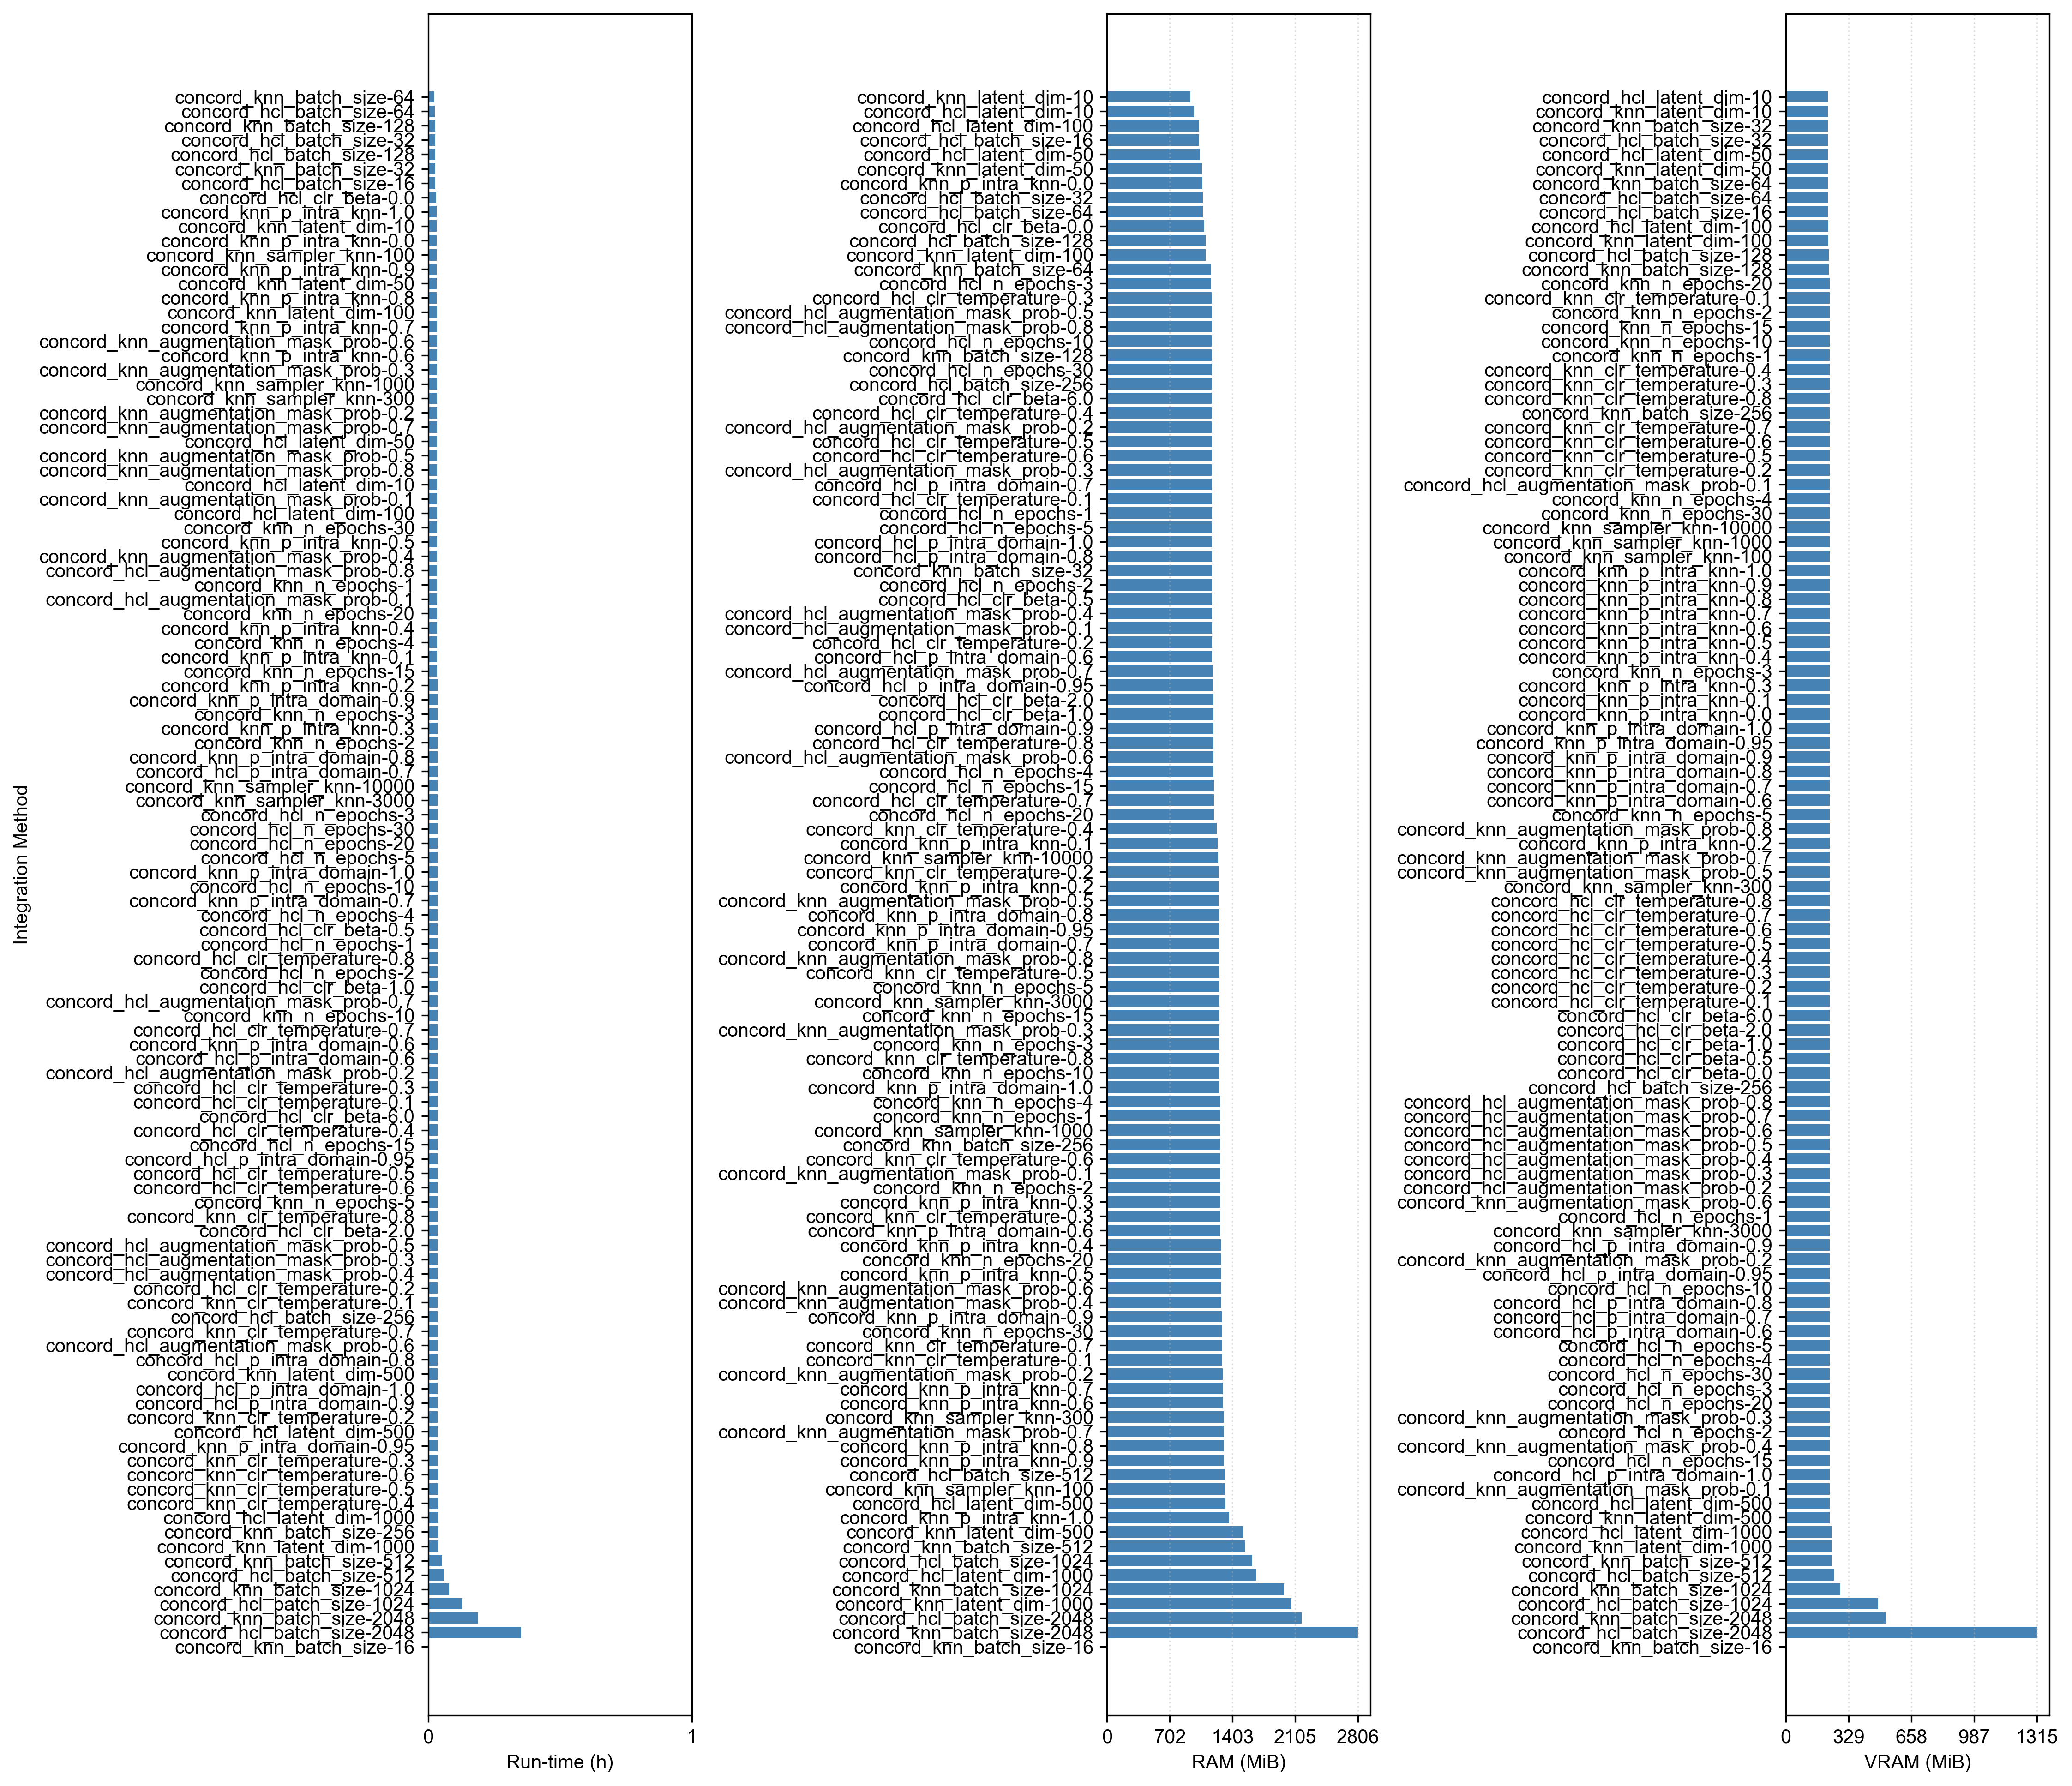

In [9]:
from benchmark_utils import collect_benchmark_logs
bench_df = collect_benchmark_logs(proj_name, methods)
# Save the benchmark results
bench_df.to_csv(save_dir / f"benchmark_summary_{file_suffix}.tsv", sep="\t", index=False)
print(f"✅ Benchmark summary saved to: {save_dir / f'benchmark_summary_{file_suffix}.tsv'}")
# Plot benchmark results
from benchmark_utils import plot_benchmark_performance
import matplotlib.pyplot as plt
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}
with plt.rc_context(rc=custom_rc):
    plot_benchmark_performance(bench_df, figsize=(15,13), dpi=300, save_path = save_dir / f"benchmark_plot_{file_suffix}.pdf")


#### Benchmark cell type

In [15]:
import numpy as np
bad_annotation = [np.nan, '', 'unknown', 'None', 'nan', 'NaN', 'NA', 'na', 'unannotated']
bad_cells = adata.obs['cell_type'].isin(bad_annotation) 
adata_ct = adata[~bad_cells].copy()
print(f"✅ Filtered adata to remove bad annotations, new shape: {adata_ct.shape}")

✅ Filtered adata to remove bad annotations, new shape: (43686, 10000)


concord.benchmarking.benchmark - INFO - Running Probe benchmark
concord.benchmarking.benchmark - INFO - Running linear probe for state with keys ['concord_hcl_augmentation_mask_prob-0.1', 'concord_hcl_augmentation_mask_prob-0.2', 'concord_hcl_augmentation_mask_prob-0.3', 'concord_hcl_augmentation_mask_prob-0.4', 'concord_hcl_augmentation_mask_prob-0.5', 'concord_hcl_augmentation_mask_prob-0.6', 'concord_hcl_augmentation_mask_prob-0.7', 'concord_hcl_augmentation_mask_prob-0.8', 'concord_hcl_batch_size-1024', 'concord_hcl_batch_size-128', 'concord_hcl_batch_size-16', 'concord_hcl_batch_size-2048', 'concord_hcl_batch_size-256', 'concord_hcl_batch_size-32', 'concord_hcl_batch_size-512', 'concord_hcl_batch_size-64', 'concord_hcl_clr_beta-0.0', 'concord_hcl_clr_beta-0.5', 'concord_hcl_clr_beta-1.0', 'concord_hcl_clr_beta-2.0', 'concord_hcl_clr_beta-6.0', 'concord_hcl_clr_temperature-0.1', 'concord_hcl_clr_temperature-0.2', 'concord_hcl_clr_temperature-0.3', 'concord_hcl_clr_temperature-0.4',

Detected task: classification
concord.benchmarking.benchmark - INFO - Running linear probe for batch with keys ['concord_hcl_augmentation_mask_prob-0.1', 'concord_hcl_augmentation_mask_prob-0.2', 'concord_hcl_augmentation_mask_prob-0.3', 'concord_hcl_augmentation_mask_prob-0.4', 'concord_hcl_augmentation_mask_prob-0.5', 'concord_hcl_augmentation_mask_prob-0.6', 'concord_hcl_augmentation_mask_prob-0.7', 'concord_hcl_augmentation_mask_prob-0.8', 'concord_hcl_batch_size-1024', 'concord_hcl_batch_size-128', 'concord_hcl_batch_size-16', 'concord_hcl_batch_size-2048', 'concord_hcl_batch_size-256', 'concord_hcl_batch_size-32', 'concord_hcl_batch_size-512', 'concord_hcl_batch_size-64', 'concord_hcl_clr_beta-0.0', 'concord_hcl_clr_beta-0.5', 'concord_hcl_clr_beta-1.0', 'concord_hcl_clr_beta-2.0', 'concord_hcl_clr_beta-6.0', 'concord_hcl_clr_temperature-0.1', 'concord_hcl_clr_temperature-0.2', 'concord_hcl_clr_temperature-0.3', 'concord_hcl_clr_temperature-0.4', 'concord_hcl_clr_temperature-0.5'

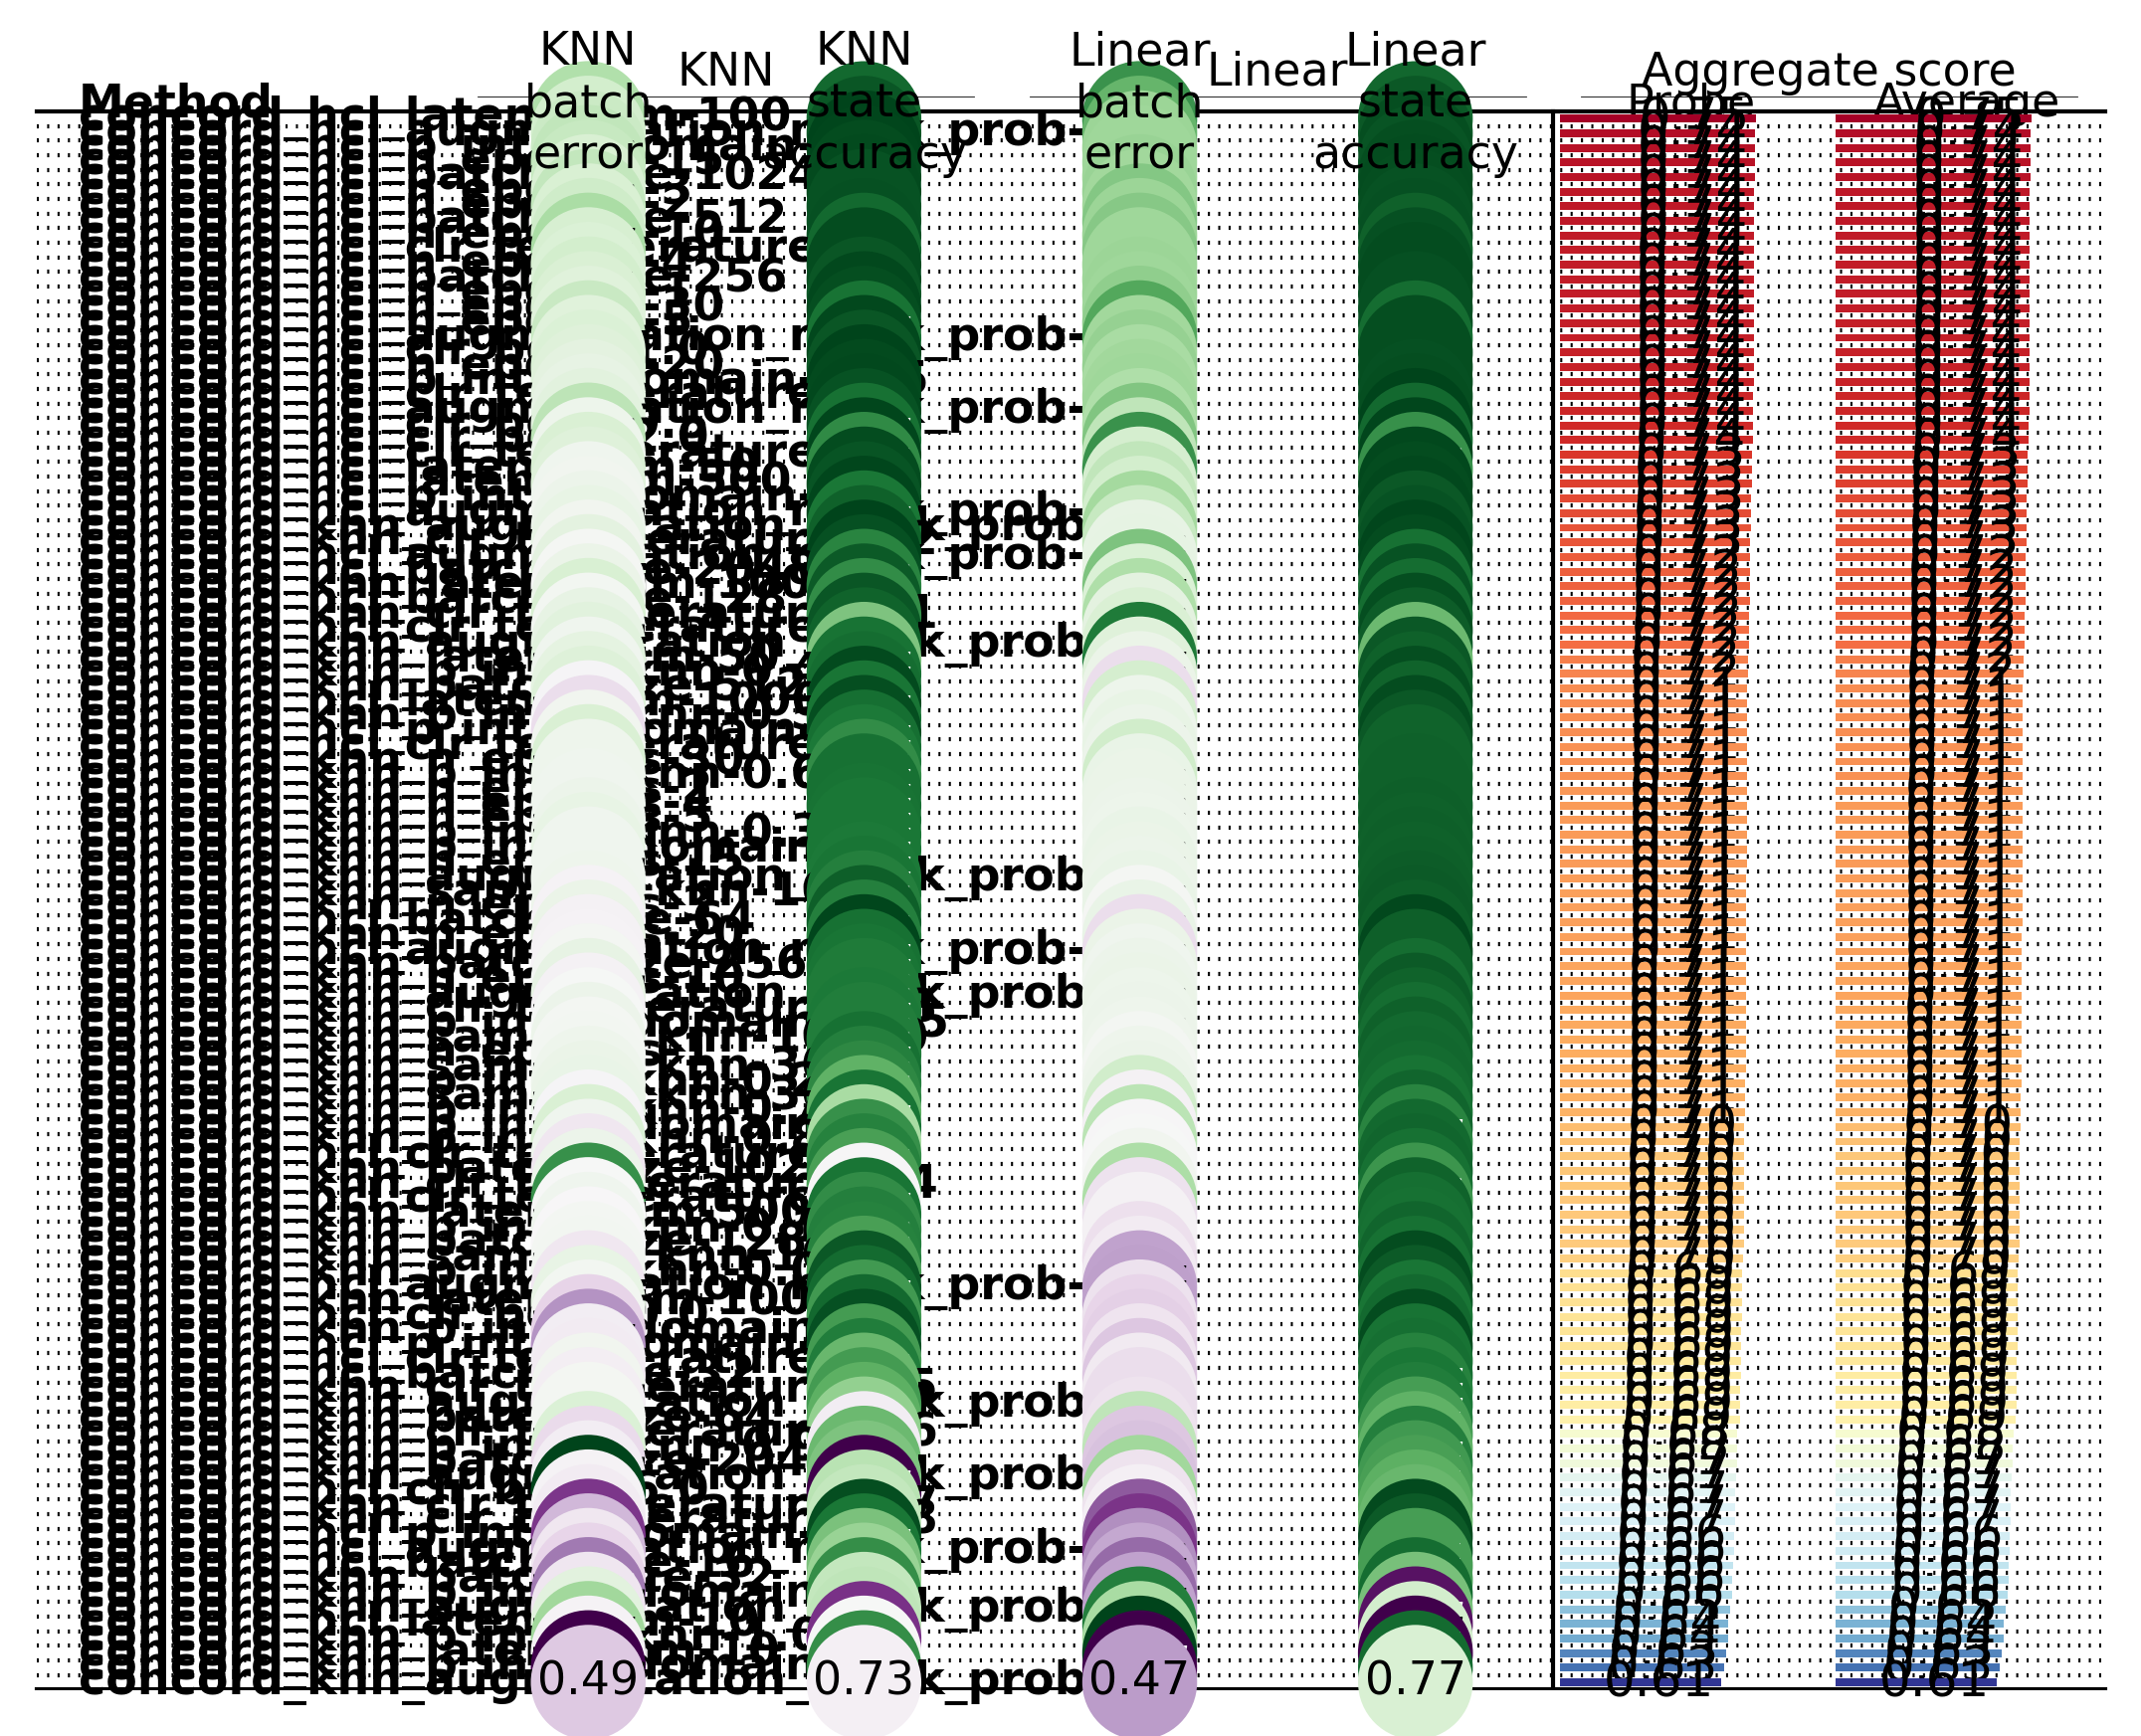

✅ Benchmark results saved to: ../save/cel_packerN2_hyperv2/benchmark_cell_type_Jul04-1429.pkl


In [16]:
state_key = 'cell_type'
batch_key = 'batch'
out = ccd.bm.run_benchmark_pipeline(
    adata_ct,
    embedding_keys=methods,
    state_key=state_key,
    batch_key=batch_key,
    save_dir=save_dir / "benchmarks_celltype",
    file_suffix=file_suffix,  # e.g. "2025-06-25"
    run=("probe"),          # run only these blocks
    plot_individual=False,          # skip the intermediate PDFs
)
combined_celltype = out["combined"]

# Save the benchmark results
import pickle
with open(save_dir / f"benchmark_{state_key}_{file_suffix}.pkl", "wb") as f:
    pickle.dump(out, f)

print(f"✅ Benchmark results saved to: {save_dir / f'benchmark_{state_key}_{file_suffix}.pkl'}")

In [17]:
combined_celltype.to_csv(save_dir / f"combined_celltype_{file_suffix}.tsv", sep="\t", index=True)
print(f"✅ Combined cell type results saved to: {save_dir / f'combined_celltype_{file_suffix}.tsv'}")

✅ Combined cell type results saved to: ../save/cel_packerN2_hyperv2/combined_celltype_Jul04-1429.tsv


In [18]:
combined_celltype

KNN                  \
                                       batch\nerror state\naccuracy   
Method                                                                
concord_hcl_latent_dim-100                 0.563516        0.876287   
concord_hcl_augmentation_mask_prob-0.2     0.548066        0.888190   
concord_hcl_p_intra_domain-1.0             0.551499        0.899748   
concord_hcl_n_epochs-15                    0.556535        0.897917   
concord_hcl_batch_size-1024                0.553674        0.894484   
...                                             ...             ...   
concord_hcl_latent_dim-10                  0.537537        0.785191   
concord_knn_p_intra_knn-1.0                0.570497        0.608492   
concord_knn_latent_dim-10                  0.518654        0.736667   
concord_knn_p_intra_domain-0.6             0.402838        0.852598   
concord_knn_augmentation_mask_prob-0.8     0.491989        0.727970   

                                             Linear                  \
                                       batch\nerror state\naccuracy   
Method                                                                
concord_hcl_latent_dim-100                 0.664416        0.885315   
concord_hcl_augmentation_mask_prob-0.2     0.640952        0.896303   
concord_hcl_p_intra_domain-1.0             0.616688        0.902598   
concord_hcl_n_epochs-15                    0.614856        0.899050   
concord_hcl_batch_size-1024                0.615658        0.902942   
...                                             ...             ...   
concord_hcl_latent_dim-10                  0.675976        0.569532   
concord_knn_p_intra_knn-1.0                0.609820        0.771317   
concord_knn_latent_dim-10                  0.716493        0.553966   
concord_knn_p_intra_domain-0.6             0.367746        0.883141   
concord_knn_augmentation_mask_prob-0.8     0.467094        0.768227   

                                       Aggregate score            
                                                 Probe   Average  
Method                                                            
concord_hcl_latent_dim-100                    0.747384  0.747384  
concord_hcl_augmentation_mask_prob-0.2        0.743378  0.743378  
concord_hcl_p_intra_domain-1.0                0.742633  0.742633  
concord_hcl_n_epochs-15                       0.742090  0.742090  
concord_hcl_batch_size-1024                   0.741689  0.741689  
...                                                ...       ...  
concord_hcl_latent_dim-10                     0.642059  0.642059  
concord_knn_p_intra_knn-1.0                   0.640032  0.640032  
concord_knn_latent_dim-10                     0.631445  0.631445  
concord_knn_p_intra_domain-0.6                0.626581  0.626581  
concord_knn_augmentation_mask_prob-0.8        0.613820  0.613820  

[108 rows x 6 columns]

#### Benchmark lineage

In [19]:
bad_annotation = [np.nan, '', 'unknown', 'None', 'nan', 'NaN', 'NA', 'na', 'unannotated']
bad_cells = adata.obs['lineage_complete'].isin(bad_annotation) 
adata_lineage = adata[~bad_cells].copy()
print(f"✅ Filtered adata to remove bad annotations, new shape: {adata_lineage.shape}")

✅ Filtered adata to remove bad annotations, new shape: (35636, 10000)


concord.benchmarking.benchmark - INFO - Running Probe benchmark
concord.benchmarking.benchmark - INFO - Running linear probe for state with keys ['concord_hcl_augmentation_mask_prob-0.1', 'concord_hcl_augmentation_mask_prob-0.2', 'concord_hcl_augmentation_mask_prob-0.3', 'concord_hcl_augmentation_mask_prob-0.4', 'concord_hcl_augmentation_mask_prob-0.5', 'concord_hcl_augmentation_mask_prob-0.6', 'concord_hcl_augmentation_mask_prob-0.7', 'concord_hcl_augmentation_mask_prob-0.8', 'concord_hcl_batch_size-1024', 'concord_hcl_batch_size-128', 'concord_hcl_batch_size-16', 'concord_hcl_batch_size-2048', 'concord_hcl_batch_size-256', 'concord_hcl_batch_size-32', 'concord_hcl_batch_size-512', 'concord_hcl_batch_size-64', 'concord_hcl_clr_beta-0.0', 'concord_hcl_clr_beta-0.5', 'concord_hcl_clr_beta-1.0', 'concord_hcl_clr_beta-2.0', 'concord_hcl_clr_beta-6.0', 'concord_hcl_clr_temperature-0.1', 'concord_hcl_clr_temperature-0.2', 'concord_hcl_clr_temperature-0.3', 'concord_hcl_clr_temperature-0.4',

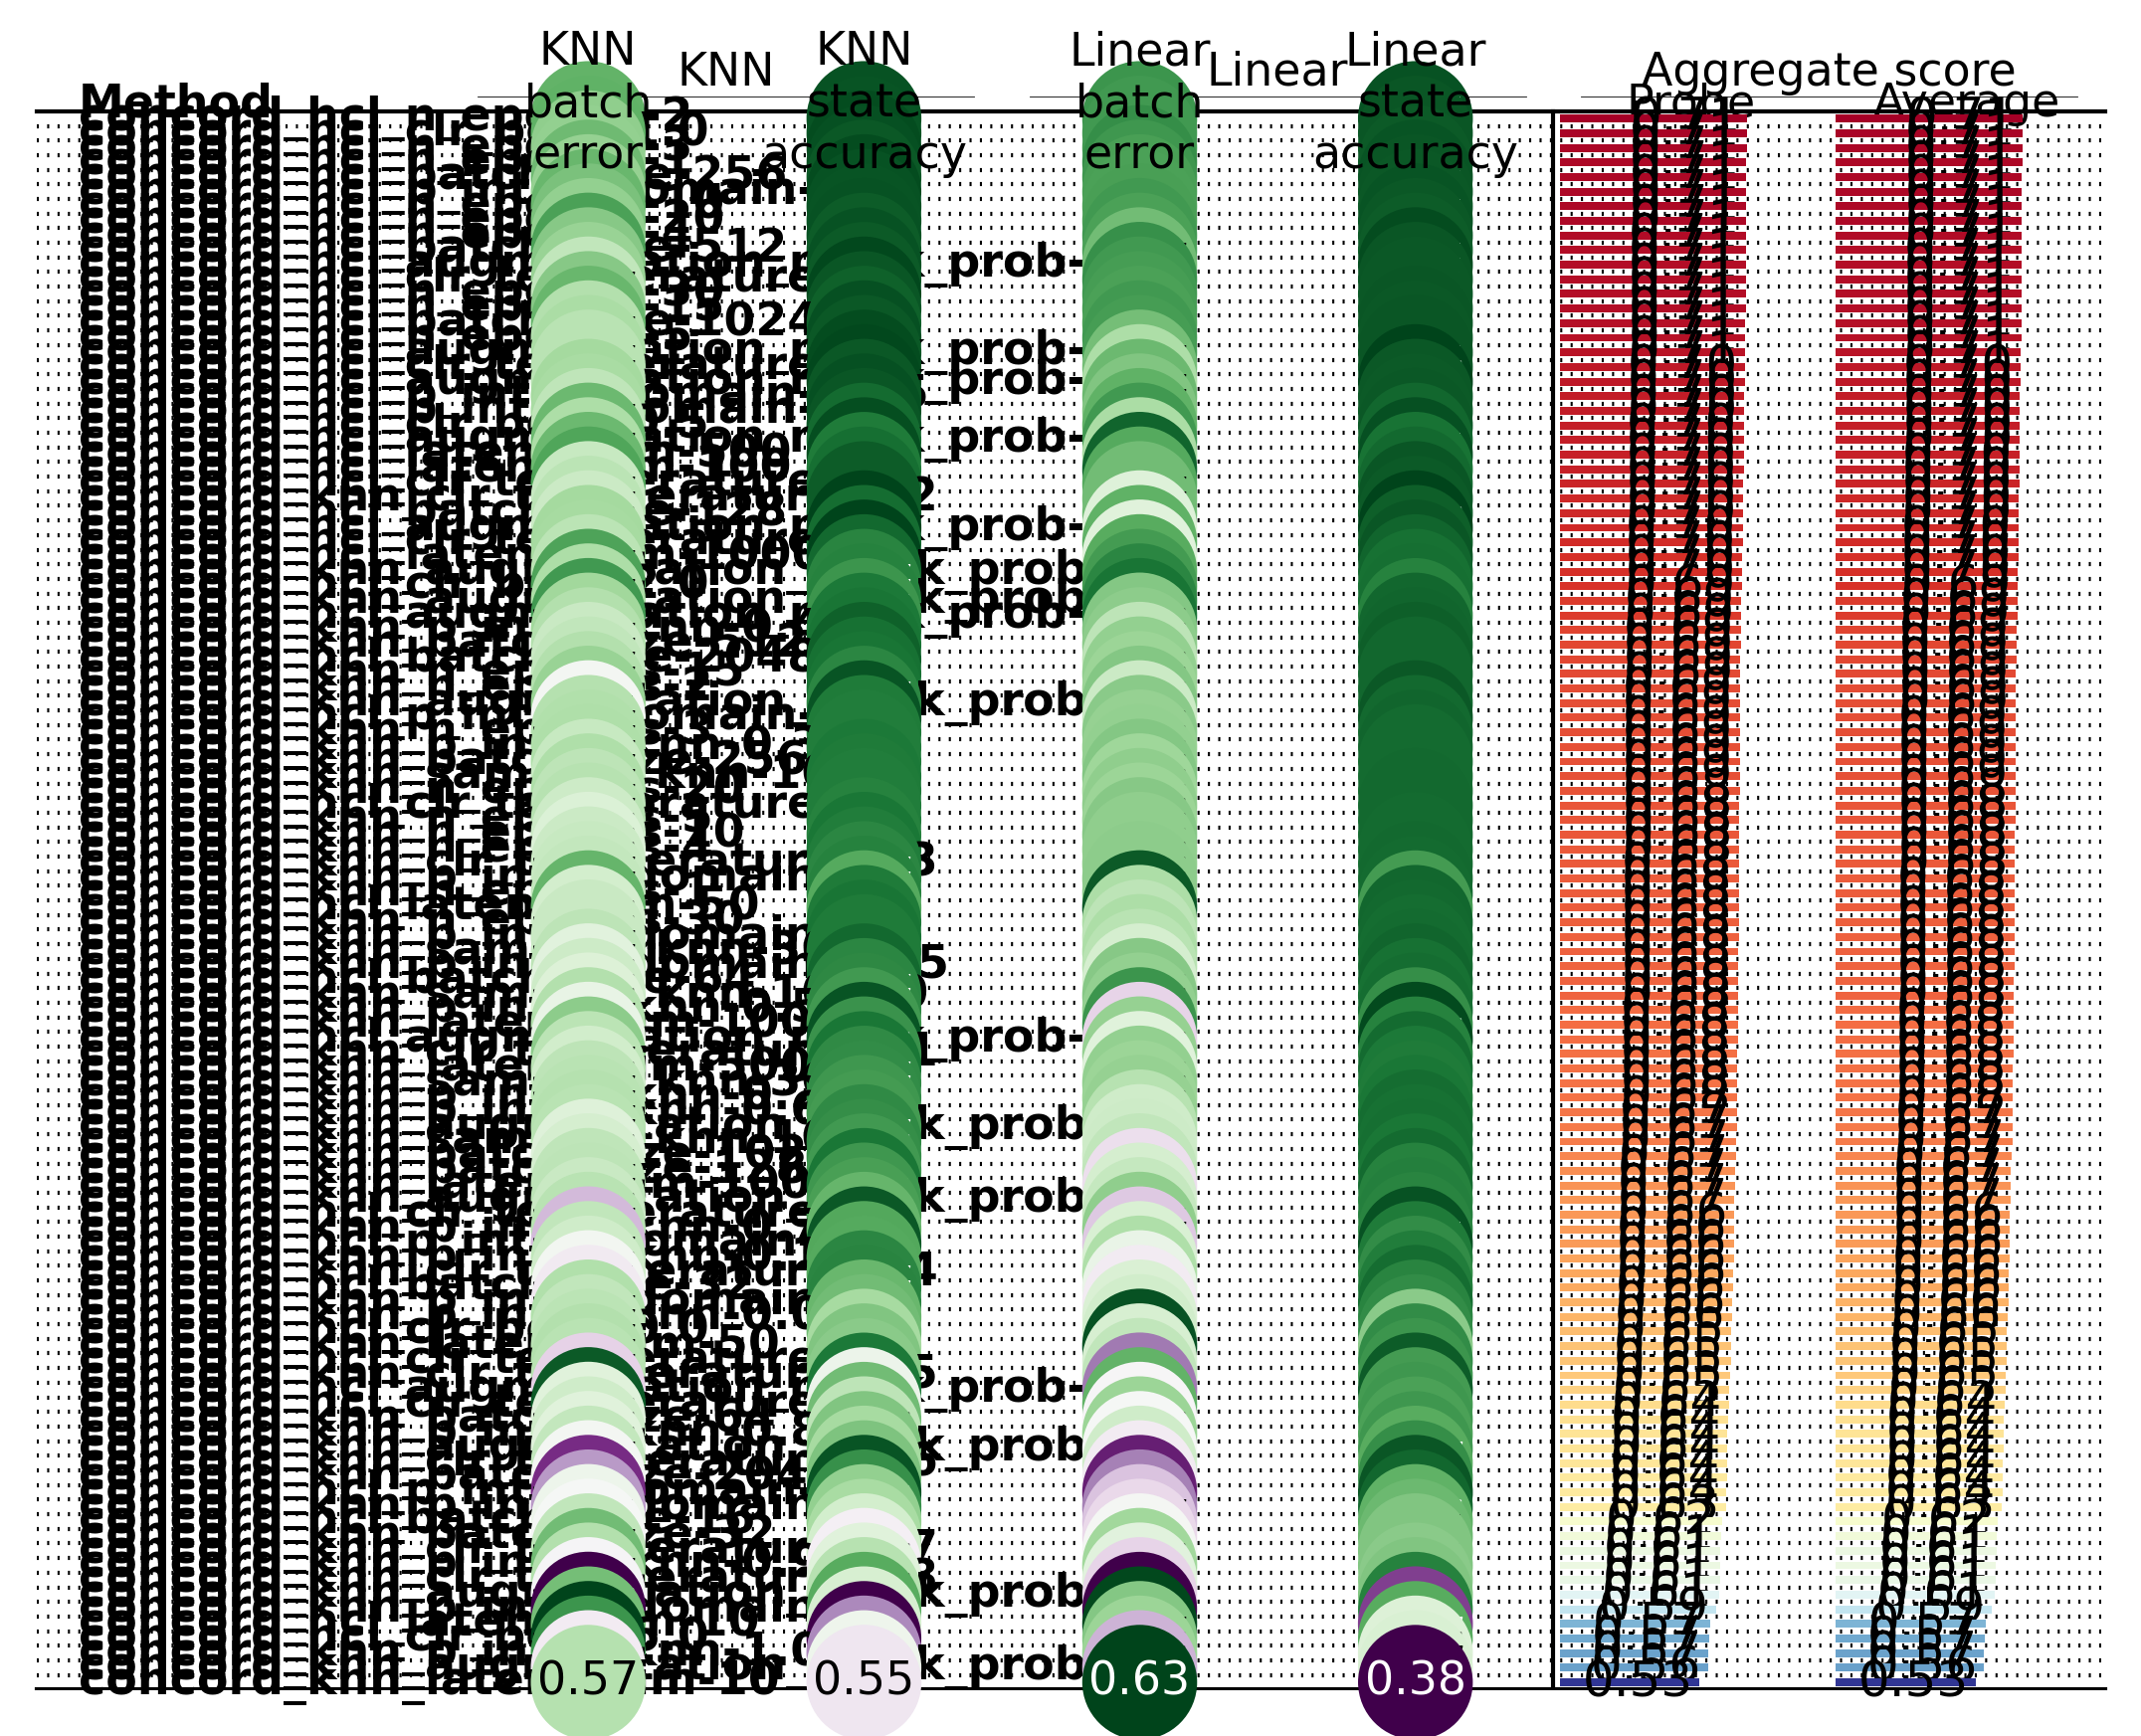

✅ Benchmark results saved to: ../save/cel_packerN2_hyperv2/benchmark_lineage_complete_Jul04-1429.pkl


In [20]:
state_key = 'lineage_complete'
batch_key = 'batch'
out = ccd.bm.run_benchmark_pipeline(
    adata_lineage,
    embedding_keys=methods,
    state_key=state_key,
    batch_key=batch_key,
    save_dir=save_dir / "benchmarks_lineage",
    file_suffix=file_suffix,  # e.g. "2025-06-25"
    run=("probe"),          # run only these blocks
    plot_individual=False,          # skip the intermediate PDFs
)
combined_lineage = out["combined"]
combined_lineage

# Save the benchmark results
import pickle
with open(save_dir / f"benchmark_{state_key}_{file_suffix}.pkl", "wb") as f:
    pickle.dump(out, f)

print(f"✅ Benchmark results saved to: {save_dir / f'benchmark_{state_key}_{file_suffix}.pkl'}")


In [21]:
combined_lineage.to_csv(save_dir / f"combined_lineage_{file_suffix}.tsv", sep="\t", index=True)
print(f"✅ Combined lineage results saved to: {save_dir / f'combined_lineage_{file_suffix}.tsv'}")

✅ Combined lineage results saved to: ../save/cel_packerN2_hyperv2/combined_lineage_Jul04-1429.tsv


### Visualize the results

In [33]:
import re
from pathlib import Path
import itertools

import pandas as pd
import matplotlib.pyplot as plt

# ───────────────────────────────────────────────────────────────
# 0  CONFIG ─ paths, metric, cosmetics
# ───────────────────────────────────────────────────────────────
SAVE_ROOT   = save_dir
FILE_SUFFIX = "Jul04-1429"

CELL_TSV   = SAVE_ROOT / f"combined_celltype_{FILE_SUFFIX}.tsv"
LINE_TSV   = SAVE_ROOT / f"combined_lineage_{FILE_SUFFIX}.tsv"

BASE_CELL  = Path("../save/cel_packerN2_hyperparam/") / f"other_celltype_Jul03-1254.tsv"
BASE_LINE  = Path("../save/cel_packerN2_hyperparam/") / f"other_lineage_Jul03-1254.tsv"

METRIC_COL = "Aggregate score.1"          # ← use any column you like

COLORS     = {"Cell type": "#1f77b4",     # consistent colour palette
              "Lineage":   "#ff7f0e"}

# dash patterns for up to 8 baselines – extend / customise as needed
DASHES = ["solid", "dashed", "dotted", "dashdot",
          (0, (3, 1, 1, 1)), (0, (5, 2)), (0, (1, 1)), (0, (5, 1, 1, 1))]
# ───────────────────────────────────────────────────────────────
# 1  Helpers
# ───────────────────────────────────────────────────────────────
score_cols = ["KNN", "KNN.1", "Linear", "Linear.1",
              "Aggregate score", "Aggregate score.1"]

_method_re = re.compile(r"concord_(hcl|knn)_(.+?)-(.+)$")

def parse_method(name: str):
    """concord_<mode>_<param>-<val>  →  (mode, param, value)."""
    m = _method_re.match(name)
    if m is None:
        return None, None, None
    mode, param, val = m.groups()
    try:
        val = float(val) if "." in val else int(val)
    except ValueError:
        pass
    return mode, param, val


def load_hyperparam_table(path: Path, target_label: str) -> pd.DataFrame:
    """Read hyper-parameter sweep table and return tidy frame."""
    df = pd.read_csv(path, sep="\t").iloc[2:].copy()
    df[score_cols] = df[score_cols].apply(pd.to_numeric, errors="coerce")
    df[["mode", "param", "value"]] = df["Unnamed: 0"].apply(
        lambda s: pd.Series(parse_method(s))
    )
    df["acc"]   = df[METRIC_COL]
    df["target"] = target_label
    return df.dropna(subset=["mode", "param"])


def load_baseline_table(path: Path, target_label: str) -> pd.DataFrame:
    """Baseline tables have one row per method (no hyper-params)."""
    df = pd.read_csv(path, sep="\t").iloc[2:].copy()
    df[score_cols] = df[score_cols].apply(pd.to_numeric, errors="coerce")
    df["method"]  = df["Unnamed: 0"].str.strip()
    df["acc"]     = df[METRIC_COL]
    df["target"]  = target_label
    return (df[["method", "acc", "target"]]
              .dropna(subset=["method"]))

# ───────────────────────────────────────────────────────────────
# 2  Load and fuse data
# ───────────────────────────────────────────────────────────────
hp_cell  = load_hyperparam_table(CELL_TSV,  "Cell type")
hp_line  = load_hyperparam_table(LINE_TSV,  "Lineage")

hyper_df = pd.concat([hp_cell, hp_line], ignore_index=True)

baseline_cell = load_baseline_table(BASE_CELL, "Cell type")
baseline_line = load_baseline_table(BASE_LINE, "Lineage")
baseline_df   = pd.concat([baseline_cell, baseline_line], ignore_index=True)

# mean across repeats (if any)
hp_summary = (hyper_df
              .groupby(["mode", "param", "value", "target"], as_index=False)["acc"]
              .mean())

base_summary = (baseline_df
                .groupby(["method", "target"], as_index=False)["acc"]
                .mean())

# Drop previous concord_hcl and concord_knn methods
base_summary = base_summary[~base_summary["method"].isin(["concord_hcl", "concord_knn", "seurat_cca"])]

# assign dash-patterns to each method
style_map = {m: d for m, d in zip(base_summary["method"].unique(),
                                  itertools.cycle(DASHES))}


In [34]:
hp_summary

mode                   param    value     target       acc
0    hcl  augmentation_mask_prob      0.1  Cell type  0.738600
1    hcl  augmentation_mask_prob      0.1    Lineage  0.691407
2    hcl  augmentation_mask_prob      0.2  Cell type  0.743378
3    hcl  augmentation_mask_prob      0.2    Lineage  0.701439
4    hcl  augmentation_mask_prob      0.3  Cell type  0.736825
..   ...                     ...      ...        ...       ...
211  knn             sampler_knn   1000.0    Lineage  0.685059
212  knn             sampler_knn   3000.0  Cell type  0.706467
213  knn             sampler_knn   3000.0    Lineage  0.675799
214  knn             sampler_knn  10000.0  Cell type  0.707611
215  knn             sampler_knn  10000.0    Lineage  0.679587

[216 rows x 5 columns]

In [35]:
hp_summary['param'].unique()

array(['augmentation_mask_prob', 'batch_size', 'clr_beta',
       'clr_temperature', 'latent_dim', 'n_epochs', 'p_intra_domain',
       'p_intra_knn', 'sampler_knn'], dtype=object)

In [38]:
# ───────────────────────────────────────────────────────────────
# Default values and recommended ranges
# ───────────────────────────────────────────────────────────────
HP_GUIDE = {
    #   param_name         default     (low ,  high)  ← inclusive
    "batch_size":          (256,        (128,   2048)),
    "latent_dim":          (100,        (50,  500)),
    "p_intra_domain":      (1.0,        (0.9,  1.0)),
    "clr_beta":            (1.0,        (0.5,  2.0)),
    "augmentation_mask_prob": (0.3,     (0.1,  0.5)),
    "clr_temperature":     (0.3,        (0.2,  0.5)),
    "n_epochs":            (10,         (5,   30)),
    "p_intra_knn":       (0.3,        (0.1,  0.5)),  # if you plot this one
    "sampler_knn":         (1000,       (300, 10000)),   # if you plot this one
}


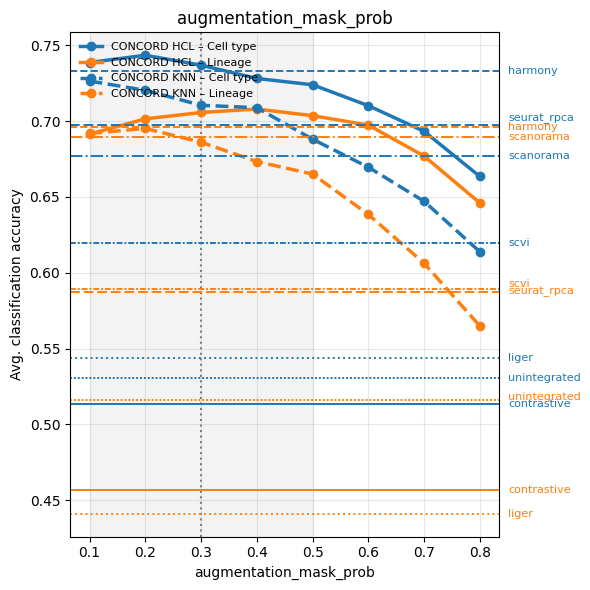

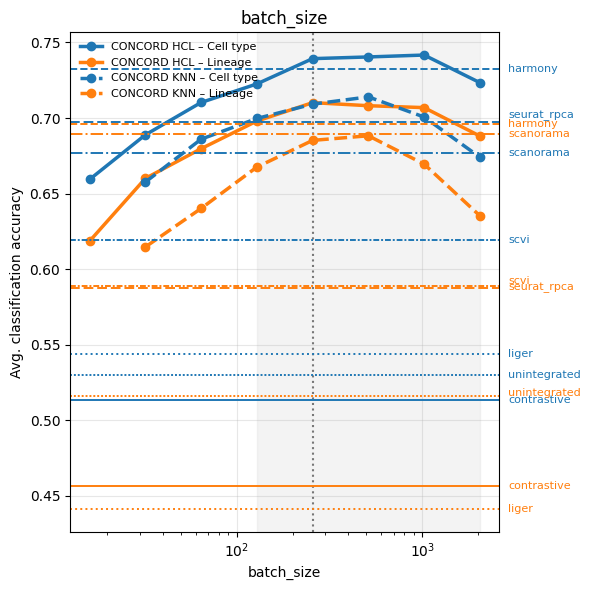

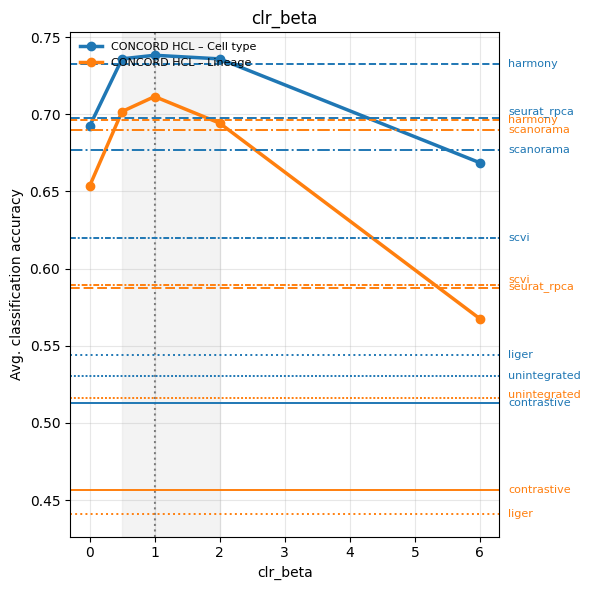

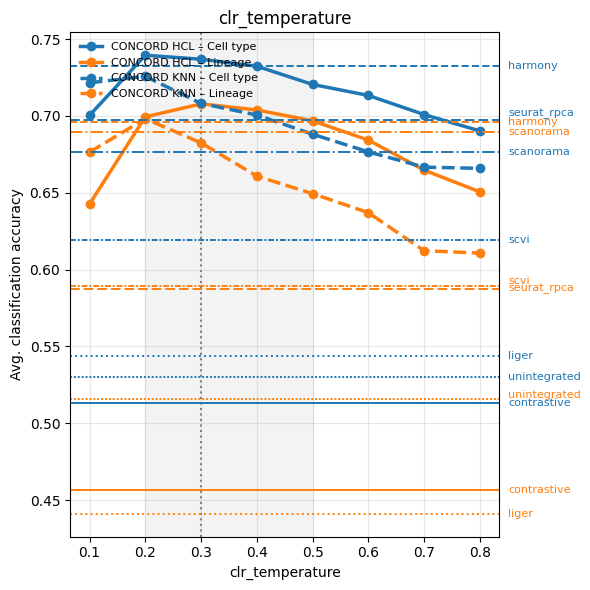

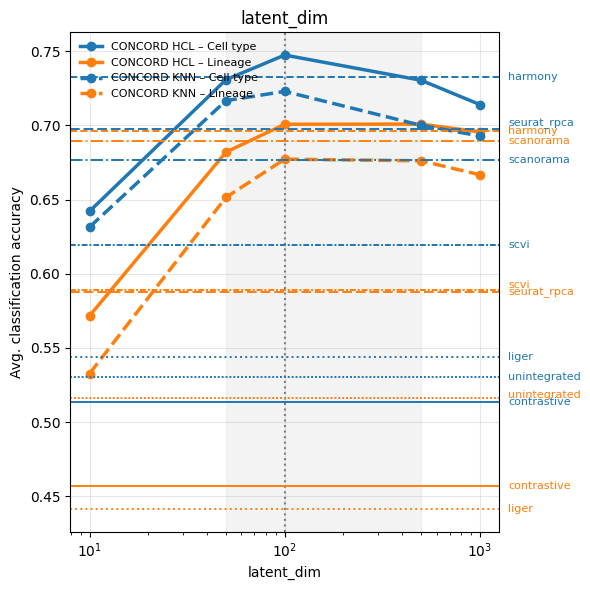

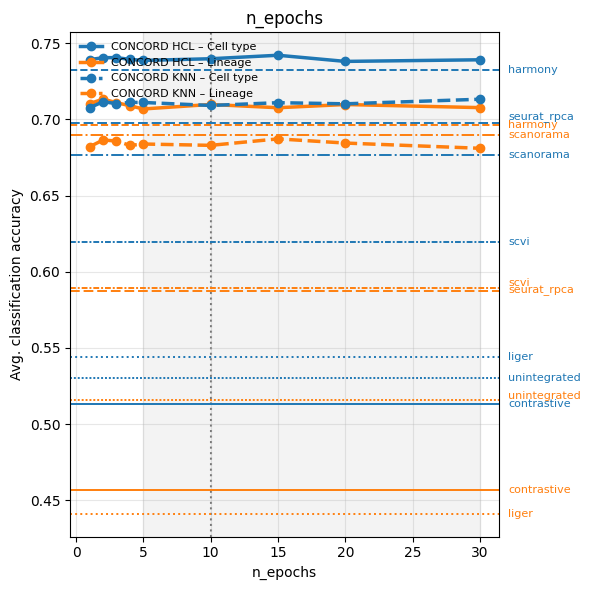

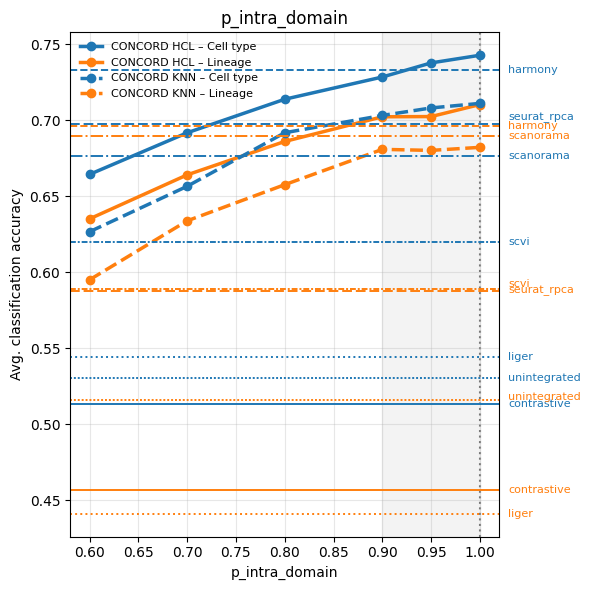

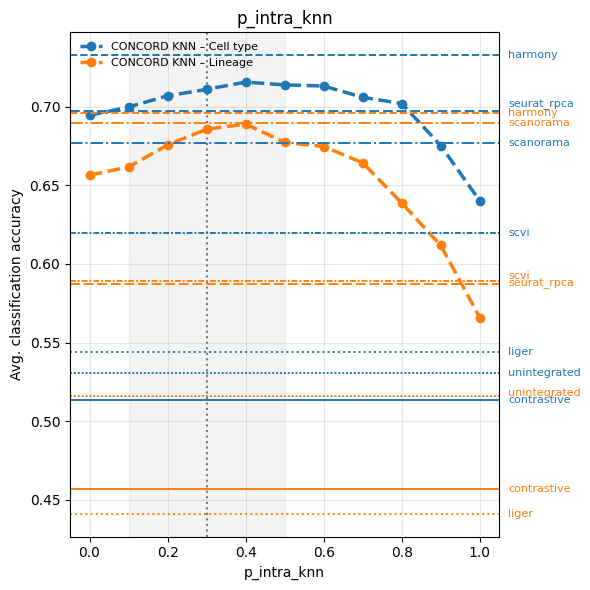

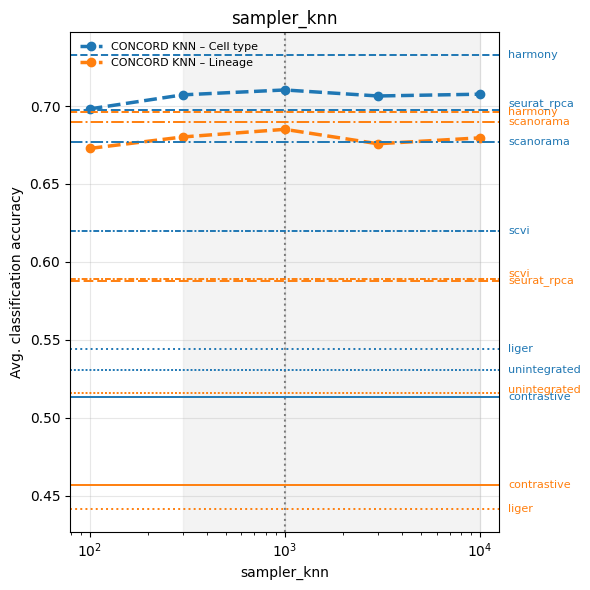

In [39]:
import numpy as np
import matplotlib.transforms as mtrans

# map CONCORD variant → line style
MODE_STYLE = {"hcl": "solid", "knn": "dashed"}
CONCORD_W  = 2.5          # linewidth for CONCORD curves
BASE_W     = 1.4          # linewidth for baselines

# ───────────────────────────────────────────────────────────────
# 3  Plot  —  HCL & k-NN together, labels outside, no overlap
# ───────────────────────────────────────────────────────────────
for param, sub in hp_summary.groupby("param"):          # ← only `param`
    fig, ax = plt.subplots(figsize=(6, 6))
    fig.subplots_adjust(right=0.78)                     # room for labels

    default, (low, high) = HP_GUIDE.get(param, (None, (None, None)))

    if default is not None:
        # vertical line
        ax.axvline(default, color="#777777", linestyle=":", linewidth=1.5,
                   zorder=0.5, label="_nolegend_")          # no legend entry
    if low is not None and high is not None:
        # shaded range
        ax.axvspan(low, high, color="#dddddd", alpha=0.35,
                   zorder=0.4, label="_nolegend_")

    # 3-A  CONCORD curves
    for (mode, tgt), grp in sub.groupby(["mode", "target"]):
        grp = grp.sort_values("value")
        ax.plot(grp["value"], grp["acc"],
                marker="o",
                linestyle=MODE_STYLE[mode],
                linewidth=CONCORD_W,
                color=COLORS[tgt],
                label=f"CONCORD {mode.upper()} – {tgt}")

    # 3-B  Baseline horizontals
    label_info = []             # collect (y, tgt, method)
    for _, row in base_summary.iterrows():
        tgt, method, y = row["target"], row["method"], row["acc"]
        ax.axhline(y, color=COLORS[tgt],
                   linestyle=style_map[method],
                   linewidth=BASE_W)
        label_info.append([y, tgt, method])

    # ──  avoid label overlap  ────────────────────────────────
    label_info.sort()                          # sort by y
    min_sep = 0.015 * np.ptp(ax.get_ylim())    # 1.5 % of y-range
    for i in range(1, len(label_info)):
        if label_info[i][0] - label_info[i-1][0] < min_sep:
            label_info[i][0] = label_info[i-1][0] + min_sep

    # keep everything inside the y-limits
    ymax = ax.get_ylim()[1]
    overshoot = label_info[-1][0] - ymax
    if overshoot > 0:
        for lab in label_info:
            lab[0] -= overshoot

    # ──  place text outside the axes  ────────────────────────
    trans = mtrans.blended_transform_factory(ax.transAxes, ax.transData)
    for y, tgt, method in label_info:
        ax.text(1.02, y, method,
                color=COLORS[tgt], fontsize=8,
                va="center", ha="left", transform=trans)

    # ──  cosmetics  ──────────────────────────────────────────
    ax.set_title(f"{param}")
    ax.set_xlabel(param)
    ax.set_ylabel("Avg. classification accuracy")

    if param in {"batch_size", "latent_dim", "sampler_knn"}:
        ax.set_xscale("log")

    ax.grid(alpha=0.3, zorder=0)
    ax.legend(frameon=False, fontsize=8, loc="upper left")

    fig.tight_layout()
    plt.show()
